In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import models, layers, losses, metrics
from keras.optimizers import Adam, SGD
import warnings
warnings.filterwarnings('ignore')

# GitHub link to access the raw dataset - https://github.com/umapavanc/MIT-Indoor-Scenes---NN/tree/main/MITIndoorScenes

C:\Users\ASUS\.conda\envs\comp258\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Mount the dataset from google drive
# from google.colab import drive
# drive.mount('/content/drive/')

In [2]:
# List of directories available under parent directory
# There are 67 subfolder with the images in it - len(class_names)
# root = '/content/drive/MyDrive/MITIndoorScenes'
root = r"D:\Fall'22\Neural Networks (SEC. 001) COMP258\Project\Datasets\MITIndoorScenes"
#r"C:\Users\vinay\OneDrive\Desktop\My_Centennial\Fall_2022\COMP_258_NN\Project\MITIndoorScenes_BD"
class_names = os.listdir(root)

## Load and Preprocess Image
### Load and scale the images from directory using the ImageDataGenerator

In [10]:
from tensorflow.keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 224, 224

image_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        zoom_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

train_ds = image_datagen.flow_from_directory(
    directory= root,
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)

valid_ds = image_datagen.flow_from_directory(
    directory= root,
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=42
)

train_ds, valid_ds
'''
Found 15620 files belonging to 67 classes.
Using 12496 files for training.
Found 15620 files belonging to 67 classes.
Using 3124 files for validation.
'''

Found 12496 images belonging to 67 classes.
Found 3094 images belonging to 67 classes.


'\nFound 15620 files belonging to 67 classes.\nUsing 12496 files for training.\nFound 15620 files belonging to 67 classes.\nUsing 3124 files for validation.\n'

In [4]:
for image_batch, labels_batch in train_ds:
    print("Shape of each batch in the generator: ", image_batch.shape)
    print(labels_batch.shape)
    break

for image_batch, labels_batch in valid_ds:
    print("Shape of each batch in the generator: ", image_batch.shape)
    print(labels_batch.shape)
    break

Shape of each batch in the generator:  (32, 224, 224, 3)
(32, 67)
Shape of each batch in the generator:  (32, 224, 224, 3)
(32, 67)


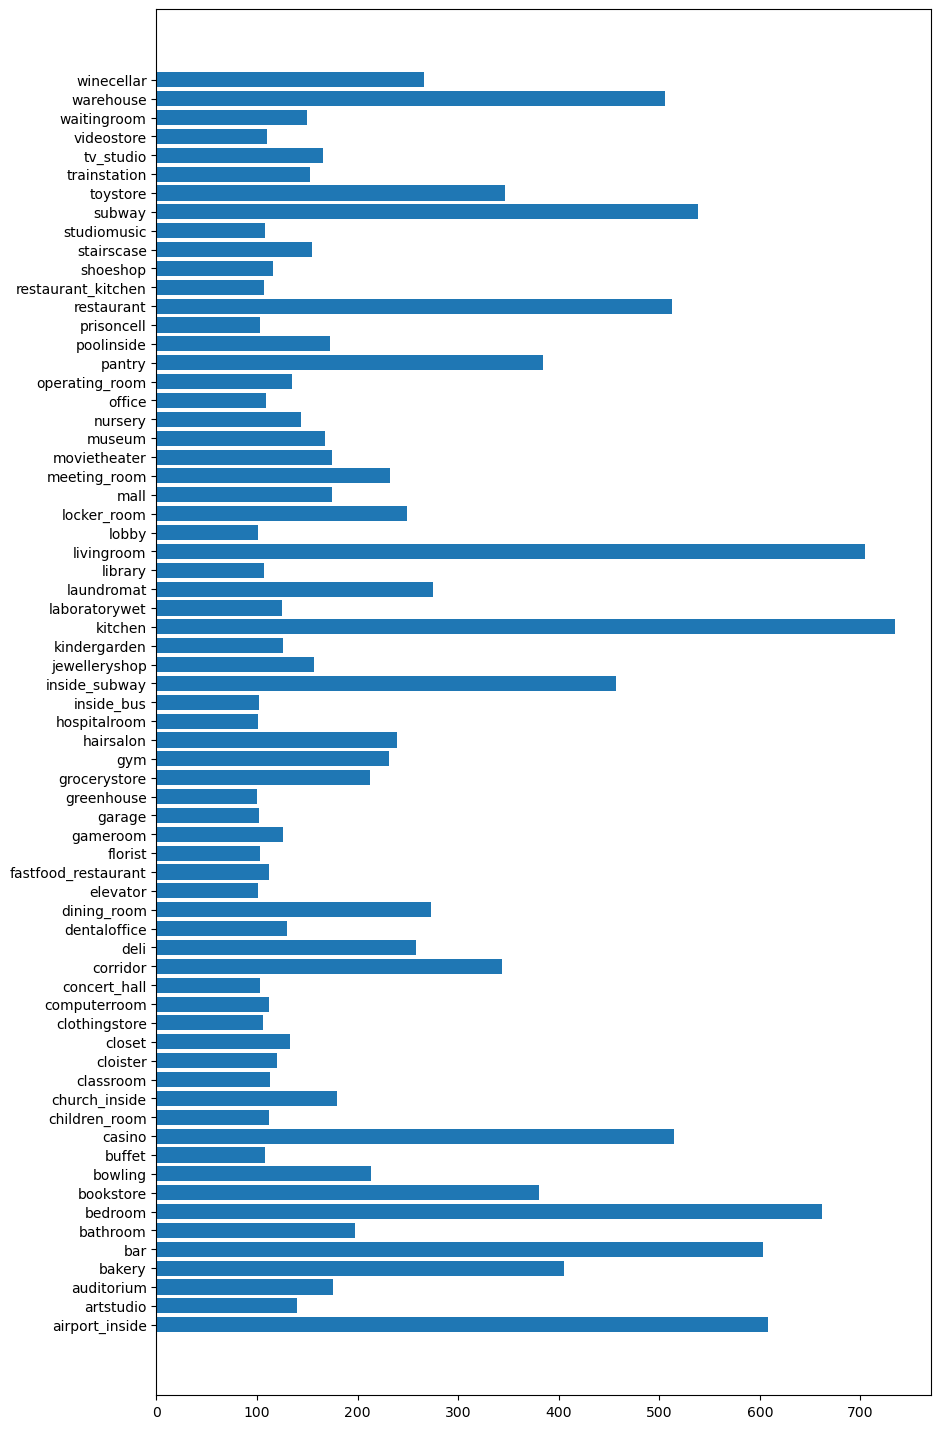

In [5]:
# Check if the dataset is imbalanced

img_count = {}
for index, dir_name in enumerate(class_names):
    subfolder = os.path.join(root,dir_name)
    img_count[dir_name] = len(os.listdir(subfolder))

f, ax = plt.subplots(figsize=(10,18))
plt.barh(list(img_count.keys()), list(img_count.values()))
plt.show()

In [6]:
label_names = train_ds.classes
print([class_names[i] for i in set(label_names)])

['airport_inside', 'artstudio', 'auditorium', 'bakery', 'bar', 'bathroom', 'bedroom', 'bookstore', 'bowling', 'buffet', 'casino', 'children_room', 'church_inside', 'classroom', 'cloister', 'closet', 'clothingstore', 'computerroom', 'concert_hall', 'corridor', 'deli', 'dentaloffice', 'dining_room', 'elevator', 'fastfood_restaurant', 'florist', 'gameroom', 'garage', 'greenhouse', 'grocerystore', 'gym', 'hairsalon', 'hospitalroom', 'inside_bus', 'inside_subway', 'jewelleryshop', 'kindergarden', 'kitchen', 'laboratorywet', 'laundromat', 'library', 'livingroom', 'lobby', 'locker_room', 'mall', 'meeting_room', 'movietheater', 'museum', 'nursery', 'office', 'operating_room', 'pantry', 'poolinside', 'prisoncell', 'restaurant', 'restaurant_kitchen', 'shoeshop', 'stairscase', 'studiomusic', 'subway', 'toystore', 'trainstation', 'tv_studio', 'videostore', 'waitingroom', 'warehouse', 'winecellar']


In [7]:
def plot_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i, image, label in zip(range(25), images, labels):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image)
        plt.title(class_names[np.argmax(label)])
        plt.axis("off")


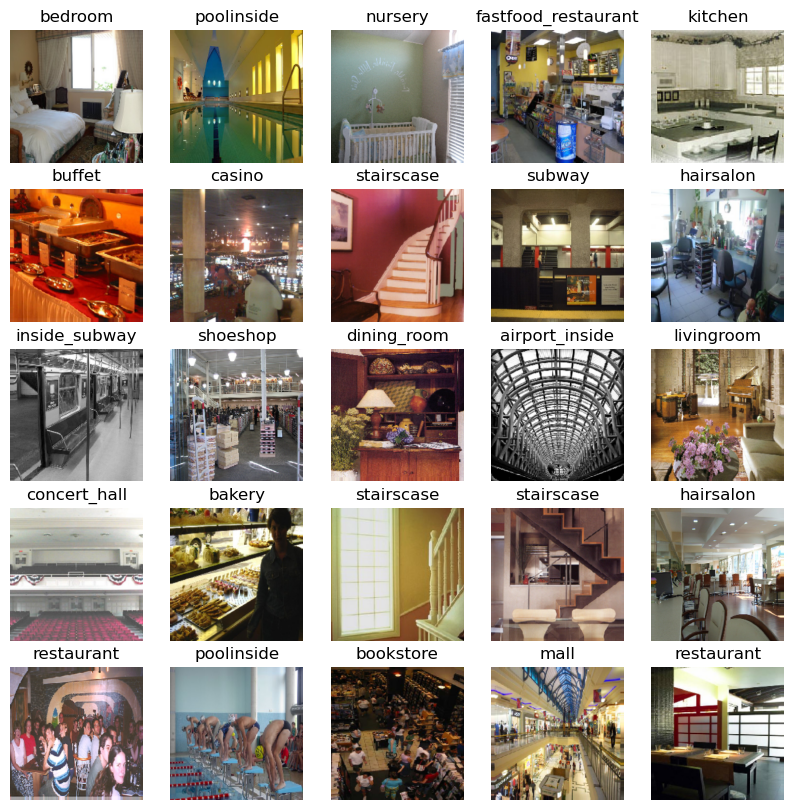

In [8]:
images, labels = train_ds[0][0], train_ds[0][1]
plot_images(images[:25], labels[:25])

!ignore - Had a problem with the below statements to imporove the model performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Training

In [11]:
def prepareModel(outputNeurons:None, learning_rate = 0.01):
    num_classes = len(class_names)
    model = models.Sequential()
    
    model.add(layers.Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))    
    model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(units=4096,activation="relu"))
    model.add(layers.Dense(units=4096,activation="relu"))
    model.add(layers.Dense(outputNeurons, activation="softmax"))

    adam = Adam(learning_rate=learning_rate)
    loss = losses.CategoricalCrossentropy()
    model.compile(loss=loss, optimizer=adam, metrics=["accuracy"])

    return model


In [12]:
model = prepareModel(len(np.unique(label_names)), 0.001)
#model.build((None, img_height, img_width,3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [12]:
STEP_SIZE_TRAIN=train_ds.n//train_ds.batch_size
STEP_SIZE_VALID=valid_ds.n//valid_ds.batch_size
STEP_SIZE_TRAIN, STEP_SIZE_VALID

(52, 13)

In [12]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

modelCheckpoint = ModelCheckpoint("MITIndoorScene_1.h5",
                                  monitor='val_acc',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=False, mode='auto', save_freq='epoch')
earlyStopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=1, verbose=1, mode='auto')
epochs = 20
history = model.fit_generator(steps_per_epoch=STEP_SIZE_TRAIN,
                           generator=train_ds, 
                           validation_data= valid_ds, 
                           validation_steps=STEP_SIZE_VALID,
                           epochs=epochs,
                           callbacks=[modelCheckpoint,earlyStopping])

#model.save("mitIndoorScene_101.h5")

Epoch 1/20
52/52 [==============================] - 2958s 57s/step - loss: 3.5371 - accuracy: 0.0723 - val_loss: 2.9847 - val_accuracy: 0.0913
Epoch 2/20
52/52 [==============================] - 2214s 42s/step - loss: 2.9868 - accuracy: 0.0936 - val_loss: 2.9807 - val_accuracy: 0.0938
Epoch 3/20
52/52 [==============================] - 1644s 31s/step - loss: 2.9835 - accuracy: 0.0942 - val_loss: 2.9798 - val_accuracy: 0.0938
Epoch 4/20
52/52 [==============================] - 1063s 20s/step - loss: 2.9825 - accuracy: 0.0948 - val_loss: 2.9800 - val_accuracy: 0.0938
Epoch 5/20
52/52 [==============================] - 914s 18s/step - loss: 2.9815 - accuracy: 0.0948 - val_loss: 2.9817 - val_accuracy: 0.0913
Epoch 6/20
52/52 [==============================] - 1042s 20s/step - loss: 2.9820 - accuracy: 0.0942 - val_loss: 2.9798 - val_accuracy: 0.0938
Epoch 7/20
52/52 [==============================] - 1063s 20s/step - loss: 2.9840 - accuracy: 0.0936 - val_loss: 2.9819 - val_accuracy: 0.0913


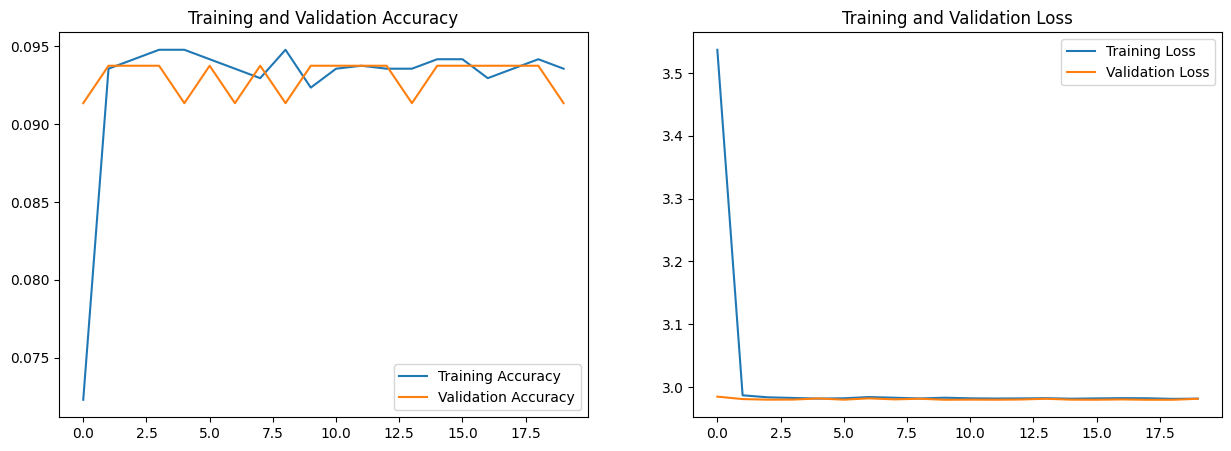

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predictions

In [30]:
test_datagen = ImageDataGenerator(rescale=1 / 255.0)
path = r"C:\Users\vinay\OneDrive\Desktop\My_Centennial\Fall_2022\COMP_258_NN\Project\test_images"
#r"D:\Fall'22\Neural Networks (SEC. 001) COMP258\Project\Datasets\test_images"
test_generator = test_datagen.flow_from_directory(
    directory= path,
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 20 images belonging to 1 classes.


In [31]:
#test_label_names = os.listdir(os.path.join(path,"predict"))
#print(len(test_label_names),"\n", os.path.split(test_label_names))

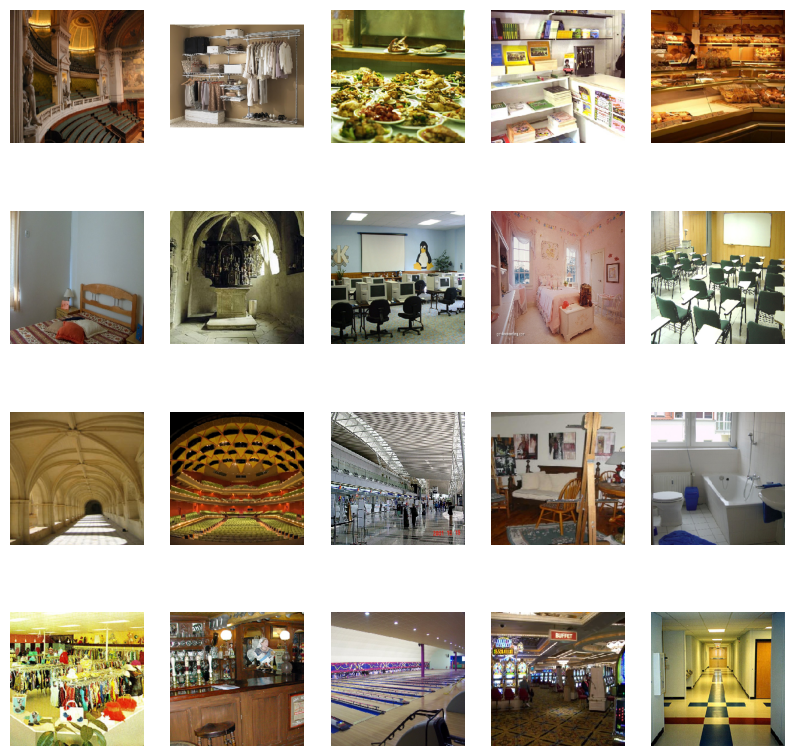

In [34]:
plt.figure(figsize=(10, 10))
for i in range(20):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(test_generator[i][0])
    #plt.title(test_label_names[i])
    plt.axis("off")



Predictions on test data

In [35]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

test_generator.reset()
pred=model.predict_generator(test_generator,
                             steps=STEP_SIZE_TEST,
                             verbose=1)
#store = model.predict(np.array([test_generator[i][0] for i in range(30)]))
predicted_class_indices=np.argmax(pred,axis=1)
[class_names[i] for i in predicted_class_indices]

20/20 [==============================] - 7s 354ms/step


['concert_hall',
 'concert_hall',
 'concert_hall',
 'concert_hall',
 'concert_hall',
 'concert_hall',
 'concert_hall',
 'concert_hall',
 'concert_hall',
 'concert_hall',
 'concert_hall',
 'concert_hall',
 'concert_hall',
 'concert_hall',
 'church_inside',
 'concert_hall',
 'church_inside',
 'concert_hall',
 'bookstore',
 'concert_hall']

In [36]:
from keras.models import load_model
model.save("MITIndoorScene_1.h5")
saved_model = load_model("MITIndoorScene_1.h5")
#output = saved_model.predict(img)

## Hypertuning

In [38]:
!pip install -q -U keras-tuner

In [13]:
# Create a model to with functions in 'hp' for tuning parameters
import keras_tuner as kt

def build_model(hp):
    model = models.Sequential()
    
    model.add(layers.Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))    
    model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))

    # Model input layer
    model.add(layers.Flatten())
    # Define the number of neurons using Int function
    hp_units = hp.Int('units', min_value=2048, max_value=5210, step=512)
    model.add(layers.Dense(units=hp_units,activation="relu"))
    model.add(layers.Dense(units=hp_units,activation="relu"))
    model.add(layers.Dense(67, activation="softmax"))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
    adam = Adam(learning_rate=hp_learning_rate)
    loss = losses.CategoricalCrossentropy()
    
    model.compile(loss=loss, optimizer=adam, metrics=["accuracy"])
    
    return model

In [52]:
tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=10, hyperband_iterations=1)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(train_ds, epochs= 10,
             validation_data = valid_ds,
             callbacks=[stop_early])

Trial 19 Complete [00h 59m 40s]
val_accuracy: 0.09307876229286194

Best val_accuracy So Far: 0.09307876229286194
Total elapsed time: 10h 20m 25s
INFO:tensorflow:Oracle triggered exit


In [53]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps)

# Get the best model
best_models_1 = tuner.get_best_models(1)[0]
# Save the model
best_models_1.save("tuned_mit_1112.h5")

In [55]:
# Use the best model and parameters to get the optimal number of epochs required to train the model
history_optimal_epochs = best_models_1.fit(train_ds,
                                           epochs=50,
                                           validation_data=valid_ds)

val_acc_per_epoch = history_optimal_epochs.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
53/53 [==============================] - 1006s 19s/step - loss: 2.9840 - accuracy: 0.0942 - val_loss: 2.9805 - val_accuracy: 0.0931
Epoch 2/50
53/53 [==============================] - 1052s 20s/step - loss: 2.9840 - accuracy: 0.0942 - val_loss: 2.9817 - val_accuracy: 0.0931
Epoch 3/50
53/53 [==============================] - 1035s 20s/step - loss: 2.9825 - accuracy: 0.0942 - val_loss: 2.9803 - val_accuracy: 0.0931
Epoch 4/50
53/53 [==============================] - 1066s 20s/step - loss: 2.9820 - accuracy: 0.0942 - val_loss: 2.9802 - val_accuracy: 0.0931
Epoch 5/50
53/53 [==============================] - 977s 18s/step - loss: 2.9817 - accuracy: 0.0942 - val_loss: 2.9801 - val_accuracy: 0.0931
Epoch 6/50
53/53 [==============================] - 900s 17s/step - loss: 2.9821 - accuracy: 0.0942 - val_loss: 2.9801 - val_accuracy: 0.0931
Epoch 7/50
53/53 [==============================] - 1075s 20s/step - loss: 2.9822 - accuracy: 0.0942 - val_loss: 2.9802 - val_accuracy: 0.0931
E

In [58]:
val_acc_per_epoch = history_optimal_epochs.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))
val_acc_per_epoch.index(max(val_acc_per_epoch))

Best epoch: 1


0

In [60]:
hypermodel = tuner.hypermodel.build(best_hps)

# Re-train the model
hypermodel.fit_generator(generator=train_ds,
                         #steps_per_epoch=STEP_SIZE_TRAIN,
                         validation_data= valid_ds,
                         #validation_steps=STEP_SIZE_VALID,
                         epochs=best_epoch)

53/53 [==============================] - 8464s 162s/step - loss: 182748320.0000 - accuracy: 0.0477 - val_loss: 162.5131 - val_accuracy: 0.0931


In [ ]:
hypermodel.save("hypermodel.h5")